Forklar at vi bliver nødt til at have objective til biomasse og bagefter 'force' fluxen for progesteron til noget bestemt. Så det er ikke 100p troværdigt fordi at progesteron ikke falder til sidst med biomassen. 

## Dynamic Flux Based Analysis

Calculating a single number for the progesterone yield and flux - as we mostly do during this report - gives little information about what the final titres will be. 
To get a better idea of how the progesterone and biomass titres change over time, it can be insightful to mimick real conditions by simulating a simple batch fermentation. This is the purpose of Dynamic Flux Based Analysis (DFBA)

We used cobra and dfba packages to make a DFBA and simulate a batch fermentation in defined intitial conditions.

In [1]:
# Load libraries
from cobra.io import read_sbml_model
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [2]:
# Loading model
infilename = 'models/iMM904_progesterone.xml'
print(f"Loading {infilename}")
model = read_sbml_model(infilename)

Loading models/iMM904_progesterone.xml


To ensure that our strain can grow while producing progesterone, we find the optimal progesterone productivity and growth rate (see 03_maximum theoretical yield). To simulate the optimal model in steady state, we define a progesterone productivity from the obtained results:

In [3]:
# max growth rate and max progesterone productivity
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.DM_progesterone_c
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth rate: {baseline_max_growth} gDW/h")
print(f"Maximum progesterone production: {baseline_max_production} mmol/gDW*h")

Maximum growth rate: 0.287865703704015 gDW/h
Maximum progesterone production: 0.16666666666666655 mmol/gDW*h


In [4]:
# growth and progesterone productivity when both are set to be objective
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone = solution.fluxes['DM_progesterone_c']
    print(f"Growth rate in complete model: {growth} gDW/h")
    print(f"Progesterone productivity in complete model: {progesterone} mmol/gDW*h")

Growth rate in complete model: 0.11872292252086913 gDW/h
Progesterone productivity in complete model: 0.15620047742340093 mmol/gDW*h


In [5]:
# Setting progesterone productivity constant
progesterone_gh = progesterone * 1000 / 314.46 # calculate progesterone productivity in g/gDW*h
print(f"Setting progesterone productivity to: {progesterone_gh} g/gDW*h")
model.reactions.DM_progesterone_c.lower_bound = progesterone_gh

Setting progesterone productivity to: 0.4967260618946796 g/gDW*h


In [6]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [7]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Pro = KineticVariable("Progesterone")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Pro])

In [8]:
# instances of ExchangeFlux

mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("DM_progesterone_c")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [9]:
# add rhs expressions for kinetic variables in dfba_model
#ENHEDER?
Vgmax = 8.5
Kg = 0.5
Gin = 100.0
Vomax = 8.0

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
#dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X )#* 180.1559 / 1000 ) #+ D * (Gin - Gluc) / V
dfba_model.add_rhs_expression("Progesterone", v_P * X )#* 314.46 / 1000 ) # - D * Pro / V

In [10]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

Oxy = 2
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

In [11]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (mmol/L)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 10.0,
        "Progesterone": 0
    }
)

In [12]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "DM_progesterone_c"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 31
Number of residual evaluations     = 102
Number of Jacobian evaluations     = 18
Number of nonlinear iterations     = 49
Number of error test failures      = 3
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 116


Final Run Statistics: 

Number of steps                    = 3
Number of residual evaluations     = 8
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 4
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 7


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluations     = 4
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 2
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 12


Final Run Statistics: 

Number of steps                    = 9
Number of residual evaluations

Text(0.5, 1.0, ' \n Batch fermentation simulation \n')

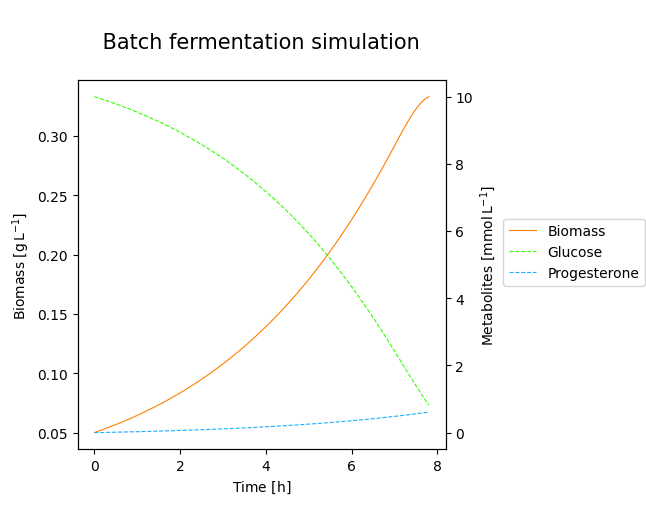

In [13]:
# plotting concentration in steady state
plot_concentrations(concentrations)
plt.title(" \n Batch fermentation simulation \n", size=15)

In [14]:
# printing concentrations in steady state
concentrations

,time,Biomass,Glucose,Progesterone
0,0.0,0.050000,10.000000,0.000000
1,0.1,0.051292,9.959006,0.002516
2,0.2,0.052618,9.916956,0.005097
3,0.3,0.053978,9.873806,0.007746
4,0.4,0.055373,9.829555,0.010463
...,...,...,...,...
74,7.4,0.317491,1.596175,0.545177
75,7.5,0.322792,1.392362,0.561082
76,7.6,0.327324,1.193239,0.577231
77,7.7,0.330868,1.001210,0.593582


In [15]:
0.61/1000 * 314.46   # mol/L * g/mol = g/L

0.19182059999999998

As seen in the figure and table above, the batch fermentaiton ran for 7.8 hours before all of the glucose was consumed. The final progesterone titre reached 0.61 mmol/L (corresponding to 0.19 g/L)
The biomass reached 0.33 gDW.

Text(0.5, 1.0, '\n Fluxes for batch fermentation simulation \n')

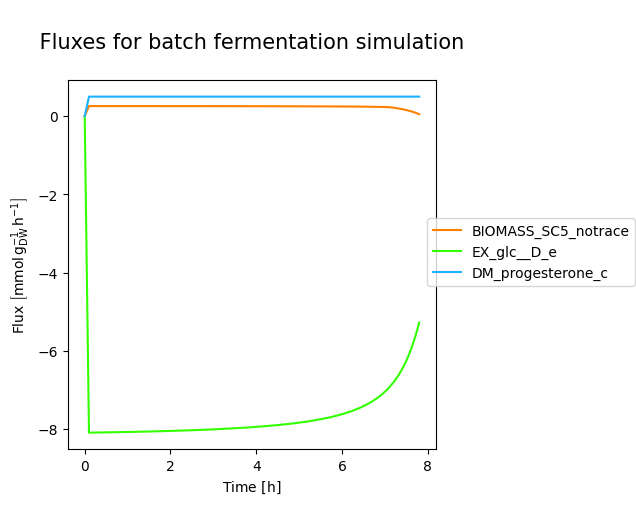

In [16]:
# Plotting fluxes at steady state
plot_trajectories(trajectories)
plt.title("\n Fluxes for batch fermentation simulation \n", size=15)

In [17]:
# printing fluxes at steady state
trajectories

,time,BIOMASS_SC5_notrace,EX_glc__D_e,DM_progesterone_c
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.255141,-8.093652,0.496726
2,0.2,0.255104,-8.092011,0.496726
3,0.3,0.255067,-8.090314,0.496726
4,0.4,0.255028,-8.088559,0.496726
...,...,...,...,...
74,7.4,0.177263,-6.472497,0.496726
75,7.5,0.153468,-6.254129,0.496726
76,7.6,0.124688,-5.990018,0.496726
77,7.7,0.089701,-5.668950,0.496726


In this simulation, the fluxes changes rapidly in the beginning, representing the speed of which glucose is consumed while biomass and progesterone is produced. The negative value for glucose means that it is removed from the media when it is consumed by *S. cerevisiae*. In constrast, the positive values for biomass and progesterone means that it is produced. 

When glucose starts to become limited after 5 hours, the glucose flux increases, i.e. it is consumed at a lower rate. It doesn't seem to affect the growth until after approximately 7 hours. 

Progesterone is produced at low levels with a constant flux of approximately 0.5. **WHY** **Fordi den er defineret til det. Så man kan sige at vi kun kan regne med plottet så længe der er steady state. Altså growth rate er konstant**